In [1]:
import matplotlib.pyplot as plt
from ptoa.data.fastmri_dataset import FastSliceDataset
import pandas as pd
import numpy as np
from pathlib import Path
from models.network import Network
import torch
from glob import glob
from torch import nn
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [2]:
l1 = nn.L1Loss()
l2 = nn.MSELoss()
tx = T.ToTensor()

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:23<00:00,  1.46it/s]


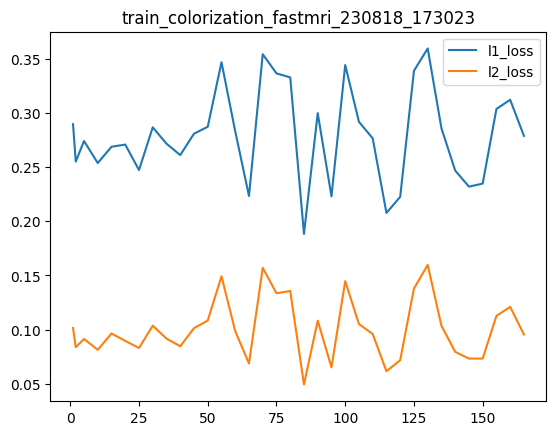

100%|██████████| 35/35 [00:24<00:00,  1.44it/s]


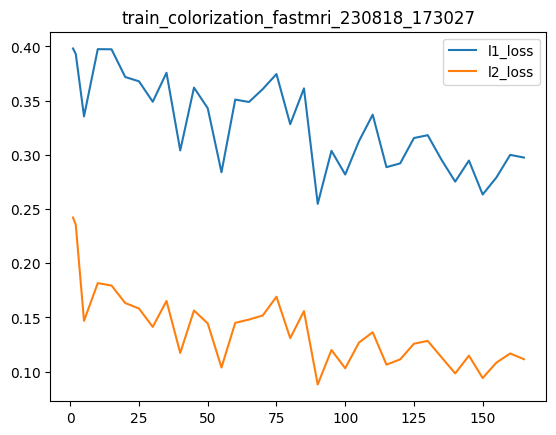

100%|██████████| 161/161 [00:56<00:00,  2.86it/s]


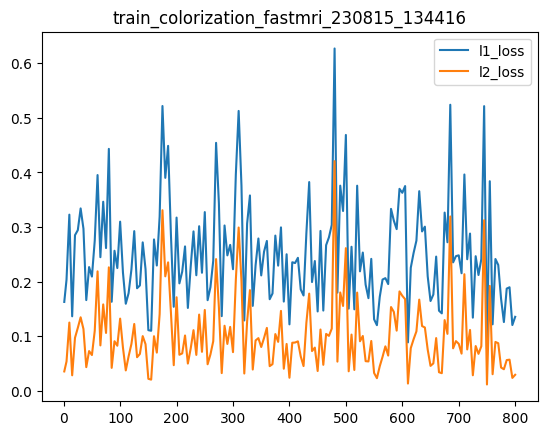

100%|██████████| 36/36 [00:12<00:00,  2.81it/s]


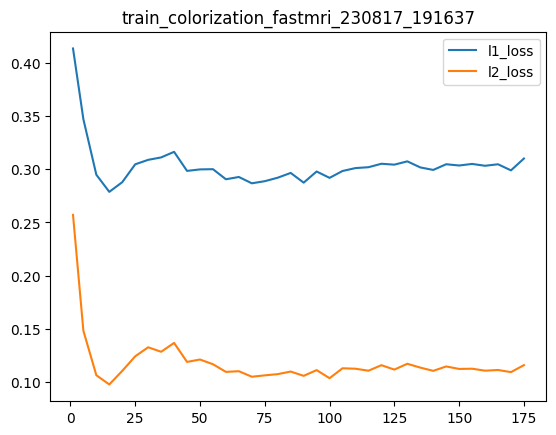

100%|██████████| 35/35 [00:23<00:00,  1.46it/s]


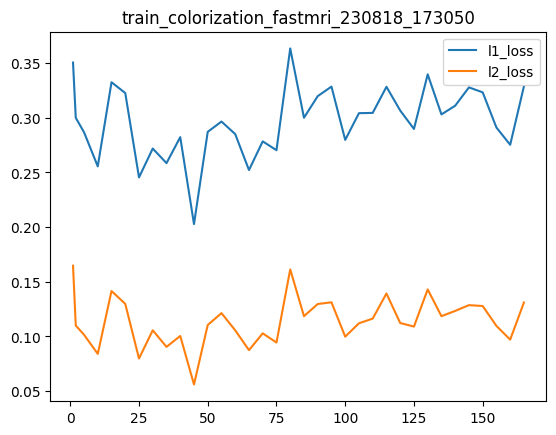

100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


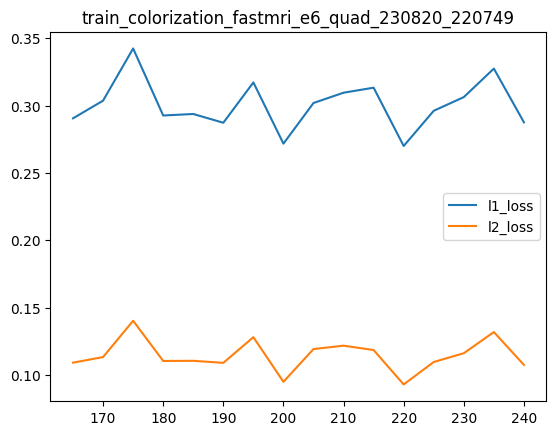

100%|██████████| 6/6 [02:33<00:00, 25.56s/it]


In [3]:

for ROOT in tqdm(glob('/home/asy51/repos/Palette-Image-to-Image-Diffusion-Models/experiments/*colorization*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    ret = {}
    for folder in tqdm(folders, position=0):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0]} for k in slcs}
        l1_loss = []
        l2_loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            l1_loss.append(l1(out_array, gt_array))
            l2_loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'l1_loss': torch.tensor(l1_loss).mean(),
            'l2_loss': torch.tensor(l2_loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    plt.plot(ret.keys(), [r['l1_loss'] for r in ret.values()], label='l1_loss')
    plt.plot(ret.keys(), [r['l2_loss'] for r in ret.values()], label='l2_loss')
    plt.title(experiment)
    plt.legend()
    plt.show()

100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


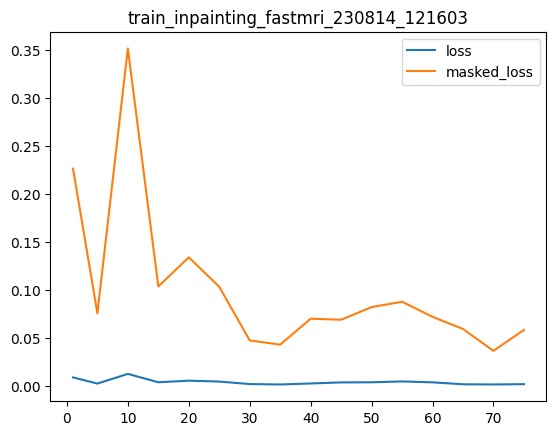

100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


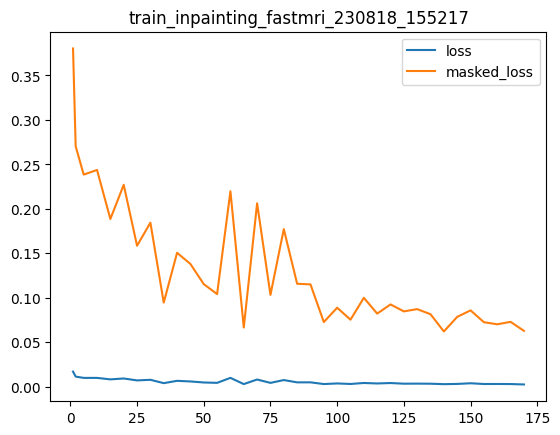

100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


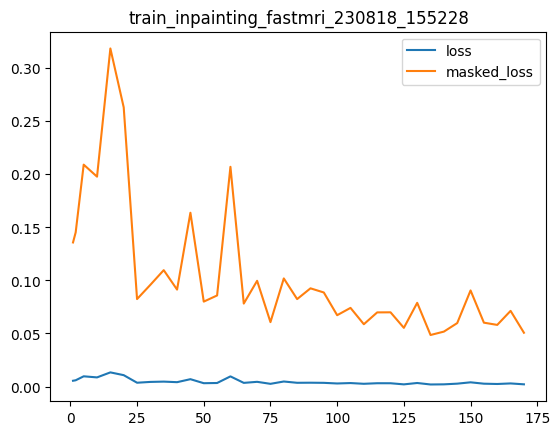

100%|██████████| 53/53 [00:49<00:00,  1.08it/s]


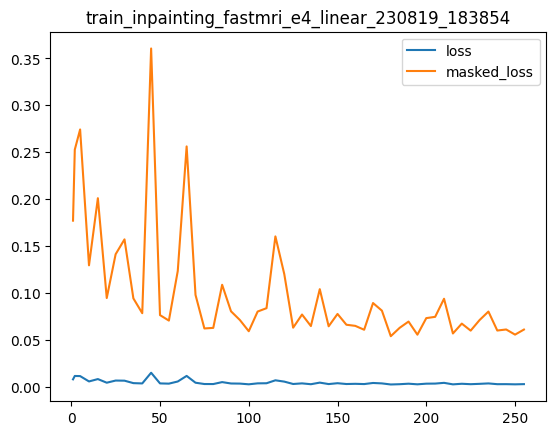

100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


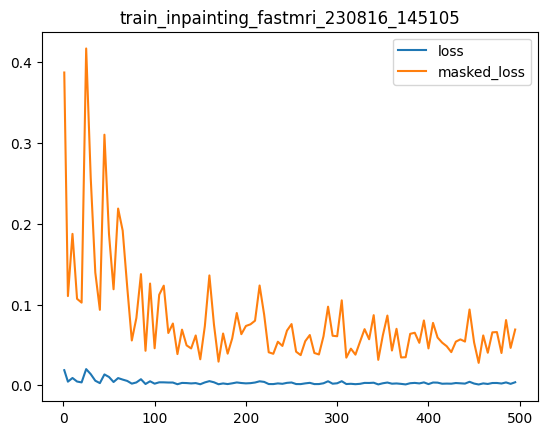

100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


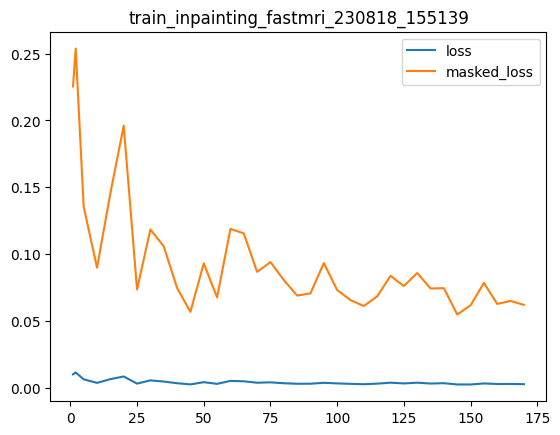

100%|██████████| 53/53 [00:50<00:00,  1.06it/s]


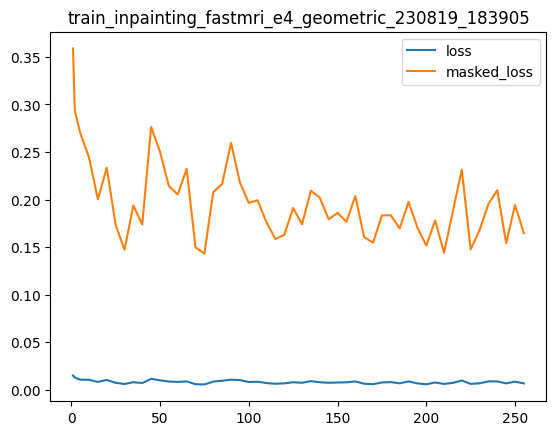

100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


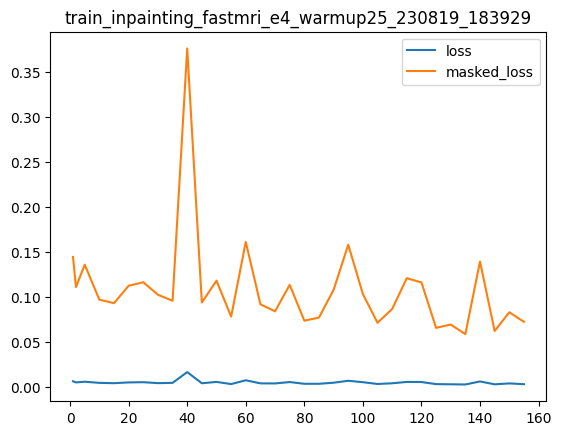

100%|██████████| 62/62 [01:06<00:00,  1.08s/it]


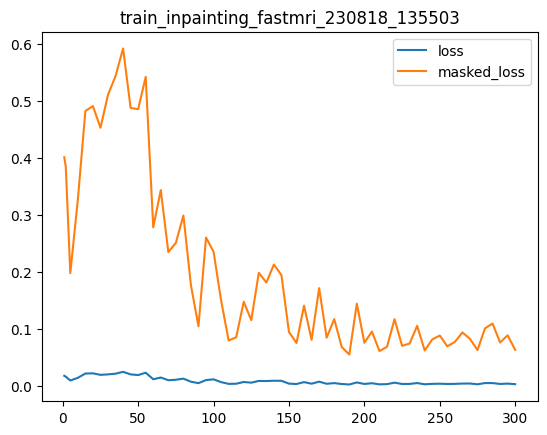

100%|██████████| 26/26 [00:24<00:00,  1.08it/s]


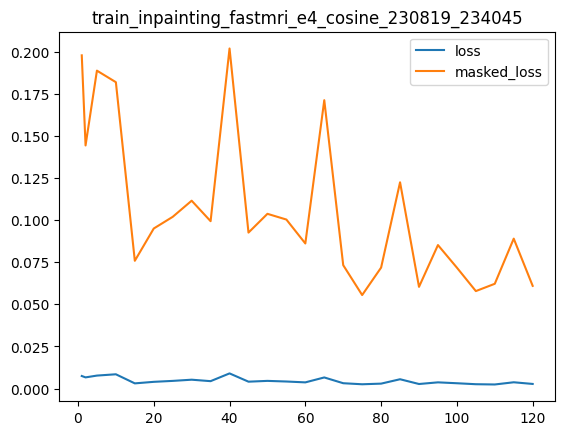

100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


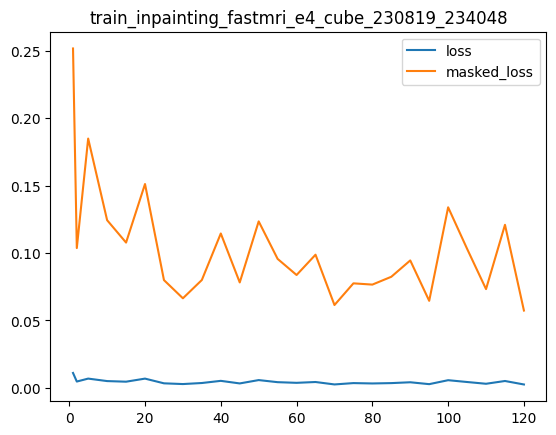

0it [00:00, ?it/s]1/15 [06:12<02:20, 35.20s/it]


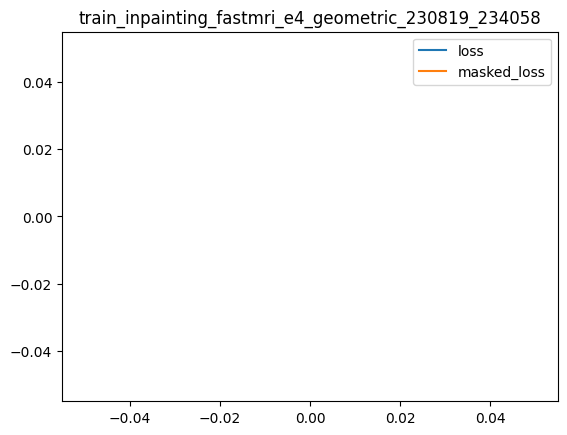

0it [00:00, ?it/s]2/15 [06:12<01:13, 24.54s/it]


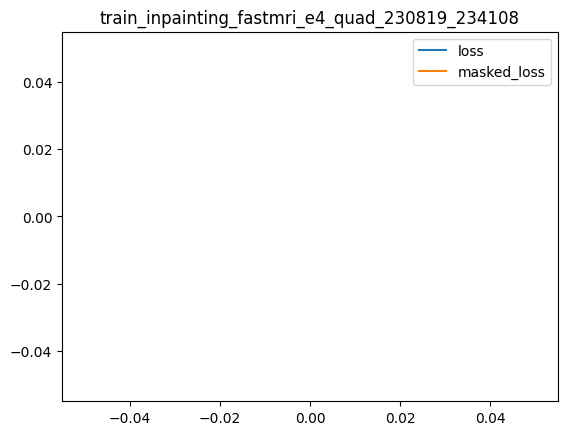

100%|██████████| 35/35 [00:32<00:00,  1.09it/s]


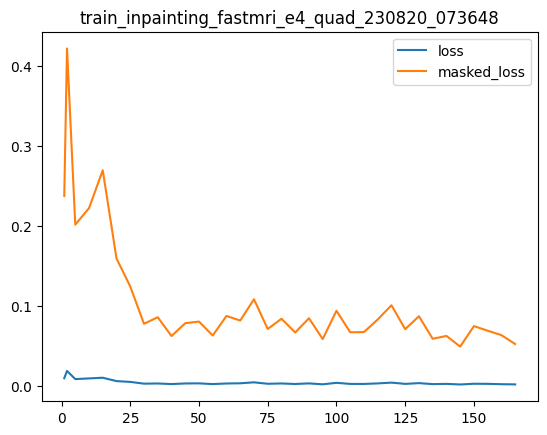

0it [00:00, ?it/s]4/15 [06:44<00:21, 21.75s/it]


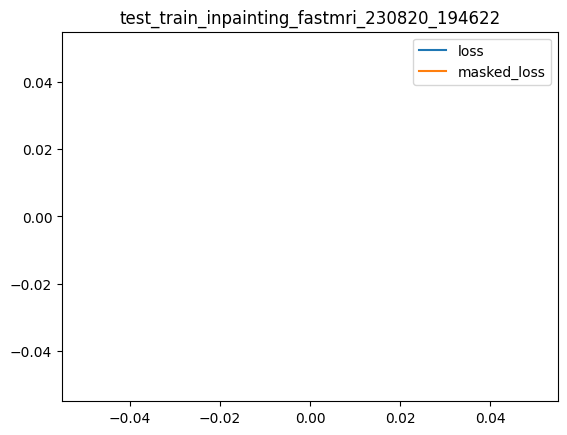

100%|██████████| 15/15 [06:44<00:00, 27.00s/it]


In [4]:

for ROOT in tqdm(glob('/home/asy51/repos/Palette-Image-to-Image-Diffusion-Models/experiments/*inpainting*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    ret = {}
    for folder in tqdm(folders, position=1):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out', 'Mask'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','').replace('Mask_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0],
            'mask': [p for p in pngs if k in p and 'Mask' in p][0]} for k in slcs}
        masked_loss = []
        loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            mask_path = slc['mask']
            mask = Image.open(mask_path)
            mask_array = tx(mask) == 1
            masked_loss.append(torch.sum(torch.abs(gt_array - out_array)) / mask_array.sum())
            loss.append(l1(out_array, gt_array))
        ret[epoch] = {
            'masked_loss': torch.tensor(masked_loss).mean(),
            'loss': torch.tensor(loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    plt.plot(ret.keys(), [r['loss'] for r in ret.values()], label='loss')
    plt.plot(ret.keys(), [r['masked_loss'] for r in ret.values()], label='masked_loss')
    plt.title(experiment)
    plt.legend()
    plt.show()